# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
import sys
from tqdm.notebook import tqdm
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from torch.utils.data import DataLoader
import matplotlib as mpl
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
import os

sys.path.append("../../..")

from src.utils.notebooks.translation.analysis import *
from src.data.datasets import IndexedTensorDataset
from src.utils.basic.io import get_genesets_from_gmt_file

mpl.rcParams["figure.dpi"] = 600


seed = 1234

device = "cuda:0"

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_in_loto_embs(
    root_dir,
    exp_dir,
    gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
):
    oe_targets = sorted(os.listdir(root_dir))

    phy_embs_dict = {}
    reg_embs_dict = {}
    for oe_target in tqdm(oe_targets):
        target_dir = os.path.join(root_dir, oe_target)
        phy_embs = pd.read_hdf(os.path.join(target_dir, "phy_embs.h5"))
        if exclude_ctrl:
            phy_embs = phy_embs.loc[phy_embs.labels != "EMPTY"]
        if avg_phy_embs:
            phy_embs_dict[oe_target] = phy_embs.groupby("labels").mean()
        else:
            phy_embs_dict[oe_target] = phy_embs

        reg_embs = pd.read_csv(
            os.path.join(target_dir, exp_dir, gae_exp, "node_embs.csv"), index_col=0
        )
        if normalize_reg_embs:
            reg_embs = pd.DataFrame(
                normalize(reg_embs), index=reg_embs.index, columns=reg_embs.columns
            )
        reg_embs_dict[oe_target] = reg_embs
    return phy_embs_dict, reg_embs_dict

<IPython.core.display.Javascript object>

In [3]:
def get_topk_acc_from_nn_dict(nn_dict, ks=list(range(50))):
    idc = []
    topk_dict = {}
    for target, nns in nn_dict.items():
        idc.append(target)
        for k in ks:
            if "top-{}".format(k) not in topk_dict:
                topk_dict["top-{}".format(k)] = []
            topk_dict["top-{}".format(k)].append(int(target in list(nns)[:k]))
    topk_result = pd.DataFrame(topk_dict, index=idc)
    return topk_result

<IPython.core.display.Javascript object>

In [4]:
def get_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for k, v in nn_dict.items():
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

<IPython.core.display.Javascript object>

In [5]:
def get_knn_dict(embs, target, k=5):
    targets = np.array(list(embs.index))
    nn = NearestNeighbors(n_neighbors=k + 1).fit(np.array(embs))
    nn_clf = CustomKNNClassifier(clf=nn, samples=targets, ks=k)
    knn_dict = {}
    for target in targets:
        preds = nn_clf.clf.kneighbors(
            np.array(embs.loc[target]).reshape(1, -1), return_distance=False
        )
        knn_dict[target] = list(targets[preds].flatten()[1:])
    knn_dict = {k: knn_dict[k] for k in sorted(knn_dict)}
    return knn_dict

<IPython.core.display.Javascript object>

In [6]:
def get_linear_comb_translation_dict(
    reg_embs_dict, phy_embs_dict, n_neighbors=5, permute=False
):
    nn_pred_dict = {}
    oe_targets = set(list(reg_embs_dict.values())[0].index)
    oe_targets = oe_targets.intersection(list(phy_embs_dict.values())[0].index)
    for target in sorted(list(oe_targets)):
        reg_embs = reg_embs_dict[target]
        phy_embs = phy_embs_dict[target]

        if permute:
            reg_embs = pd.DataFrame(
                np.random.permutation(np.array(reg_embs)),
                index=reg_embs.index,
                columns=reg_embs.columns,
            )
            phy_embs = pd.DataFrame(
                np.random.permutation(np.array(phy_embs)),
                index=phy_embs.index,
                columns=phy_embs.columns,
            )

        shared_targets = set(reg_embs.index).intersection(phy_embs.index)
        phy_embs = phy_embs.loc[shared_targets]

        reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
        reg_samples = np.array(list(reg_embs.index))
        reg_nn.fit(np.array(reg_embs))

        phy_samples = np.array(list(phy_embs.index))
        phy_nn = NearestNeighbors(n_neighbors=len(phy_samples))
        phy_nn.fit(np.array(phy_embs))

        x = phy_embs.loc[phy_samples == target]
        phy_nns = phy_samples[phy_nn.kneighbors(np.array(x), return_distance=False)][0][
            1:
        ]
        phy_nns = phy_nns[:n_neighbors]

        X = phy_embs.loc[phy_embs.index.isin(phy_nns)]

        alpha = np.matmul(np.array(x), np.linalg.pinv(np.array(X)))

        Y = reg_embs.loc[X.index]
        y = np.matmul(alpha, np.array(Y))

        reg_nns = reg_samples[reg_nn.kneighbors(y, return_distance=False)][0]
        nn_pred_dict[target] = reg_nns
    return nn_pred_dict

<IPython.core.display.Javascript object>

In [7]:
def get_nn_comb_results(reg_embs_dict, phy_embs_dict, ks=None, ns=None):
    n_shared_targets = len(
        set(list(phy_embs_dict.values())[0].index).intersection(
            list(reg_embs_dict.values())[0].index
        )
    )
    if ns is None:
        ns = [1, 2, 3, 5, 10, 20, 30, n_shared_targets - 1]
    if ks is None:
        ks = list(range(1, 51))
    nn_comb_results = {"topk_acc": [], "k": [], "l": []}
    for n in ns:
        nn_comb_nn_dict = get_linear_comb_translation_dict(
            reg_embs_dict=reg_embs_dict,
            phy_embs_dict=phy_embs_dict,
            n_neighbors=n,
            permute=False,
        )
        nn_comb_nn_topk = get_topk_acc_from_nn_dict(nn_comb_nn_dict, ks=ks)
        nn_comb_result = nn_comb_nn_topk.mean()
        for k in ks:
            nn_comb_results["topk_acc"].append(nn_comb_result.loc["top-{}".format(k)])
            nn_comb_results["k"].append(k)
            nn_comb_results["l"].append(str(n))
    nn_comb_results = pd.DataFrame(nn_comb_results)
    return nn_comb_results

<IPython.core.display.Javascript object>

In [8]:
def get_perm_nn_comb_results(
    reg_embs_dict,
    phy_embs_dict,
    ks=None,
    ns=None,
    b=500,
    random_state=1234,
    n_clusters=None,
):

    if n_clusters is not None:
        reduced_reg_embs_dict = get_reduced_reg_embs_dict(
            reg_embs_dict, n_clusters=n_clusters
        )
    else:
        reduced_reg_embs_dict = reg_embs_dict

    n_shared_targets = len(
        set(list(phy_embs_dict.values())[0].index).intersection(
            list(reduced_reg_embs_dict.values())[0].index
        )
    )

    np.random.seed(random_state)
    if ns is None:
        ns = [1, 2, 3, 4, 5, 10, 20, 30, n_shared_targets - 1]
    if ks is None:
        ks = list(range(1, 51))
    nn_comb_results = {"topk_acc": [], "k": [], "l": []}
    for i in tqdm(range(b)):
        for n in ns:

            nn_comb_nn_dict = get_linear_comb_translation_dict(
                reg_embs_dict=reduced_reg_embs_dict,
                phy_embs_dict=phy_embs_dict,
                n_neighbors=n,
                permute=True,
            )
            nn_comb_nn_topk = get_topk_acc_from_nn_dict(nn_comb_nn_dict, ks=ks)
            nn_comb_result = nn_comb_nn_topk.mean()
            for k in ks:
                nn_comb_results["topk_acc"].append(
                    nn_comb_result.loc["top-{}".format(k)]
                )
                nn_comb_results["k"].append(k)
                nn_comb_results["l"].append(str(n))
    nn_comb_results = pd.DataFrame(nn_comb_results)
    return nn_comb_results

<IPython.core.display.Javascript object>

In [9]:
def get_reduced_reg_embs_dict(
    reg_embs_dict, n_clusters=5, affinity="euclidean", linkage="complete"
):
    reduced_reg_embs_dict = copy.deepcopy(reg_embs_dict)
    for k, v in reduced_reg_embs_dict.items():
        agglo_cl = AgglomerativeClustering(
            n_clusters=n_clusters, affinity=affinity, linkage=linkage
        )
        cluster_labels = agglo_cl.fit_predict(np.array(v))
        cluster_labels = pd.DataFrame(
            cluster_labels, columns=["cluster"], index=v.index
        )
        target_clusters = np.unique(
            cluster_labels.loc[
                cluster_labels.index.isin(list(reduced_reg_embs_dict.keys()))
            ]
        )
        reduced_reg_embs_dict[k] = v.loc[
            cluster_labels.loc[cluster_labels.cluster.isin(target_clusters)].index
        ]
    return reduced_reg_embs_dict

<IPython.core.display.Javascript object>

In [10]:
def plot_translation_performance(
    results,
    perm_results,
    perm_cluster_results,
    hue,
    ymax,
    title="",
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    perm_l=None,
    param_title=None,
):
    if param_title is None:
        param_title = hue
    if perm_l is None:
        perm_l = "1"
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.lineplot(
        data=results,
        x="k",
        y="topk_acc",
        hue=hue,
        palette=cmap,
        style=style,
        style_order=style_order,
    )
    ax = sns.lineplot(
        data=perm_results.loc[perm_results.l == perm_l],
        x="k",
        y="topk_acc",
        ax=ax,
        label="random",
        color="dimgray",
        legend=False,
    )
    if perm_cluster_results is not None:
        ax = sns.lineplot(
            data=perm_cluster_results.loc[perm_cluster_results.l == perm_l],
            x="k",
            y="topk_acc",
            ax=ax,
            label="random_cluster",
            color="silver",
            legend=False,
        )
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, ymax, 0.05))
    start_idx = -1 - (perm_cluster_results is not None)

    # Add two legends
    lines = np.array(list(ax.get_lines()))
    labels = np.array([str(line.get_label()) for line in lines])
    filter_idc = []
    for i in range(len(labels)):
        label = labels[i]
        if not label.startswith("_"):
            filter_idc.append(i)
    lines = lines[filter_idc]
    labels = labels[filter_idc]
    if style is not None:
        leg1 = ax.legend(
            lines[:start_idx],
            labels[:start_idx],
            loc="upper left",
            ncol=1,
            fancybox=True,
            frameon=True,
            edgecolor="k",
        )
    else:
        leg1 = ax.legend(
            lines[:start_idx],
            labels[:start_idx],
            loc="upper left",
            ncol=1,
            title=param_title,
            fancybox=True,
            frameon=True,
            edgecolor="k",
        )
    leg2 = ax.legend(
        lines[start_idx:],
        labels[start_idx:],
        loc="lower right",
        title="baseline",
        fancybox=True,
        frameon=True,
        edgecolor="k",
    )
    ax.add_artist(leg1)

    return fig, ax

<IPython.core.display.Javascript object>

In [ ]:
def plot_translation_performance_one_legend(
    results,
    perm_results,
    perm_cluster_results,
    hue,
    ymax,
    title="",
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    perm_l=None,
    param_title=None,
):
    if param_title is None:
        param_title = hue
    if perm_l is None:
        perm_l = "1"
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.lineplot(
        data=results,
        x="k",
        y="topk_acc",
        hue=hue,
        palette=cmap,
        style=style,
        style_order=style_order,
    )
    ax = sns.lineplot(
        data=perm_results.loc[perm_results.l == perm_l],
        x="k",
        y="topk_acc",
        ax=ax,
        label="Random baseline",
        color="dimgray",
        legend=False,
    )
    if perm_cluster_results is not None:
        ax = sns.lineplot(
            data=perm_cluster_results.loc[perm_cluster_results.l == perm_l],
            x="k",
            y="topk_acc",
            ax=ax,
            label="Random cluster baseline",
            color="silver",
            legend=False,
        )
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, ymax, 0.05))
    ax.legend(title="Model", loc="upper left", frameon=True)

    return fig, ax

In [ ]:
def get_all_loto_performance_results(
    reg_embs_dict, phy_embs_dict, alpha, beta, gamma, graph, cluster, b=50, n_clusters=5
):
    nn_comb_results = get_nn_comb_results(
        reg_embs_dict=reg_embs_dict, phy_embs_dict=phy_embs_dict
    )
    nn_comb_results["alpha"] = alpha
    nn_comb_results["beta"] = beta
    nn_comb_results["gamma"] = gamma
    nn_comb_results["graph"] = graph
    nn_comb_results["cluster"] = cluster

    perm_nn_comb_results = get_perm_nn_comb_results(
        reg_embs_dict=reg_embs_dict, phy_embs_dict=phy_embs_dict, b=b
    )
    perm_nn_comb_results["alpha"] = alpha
    perm_nn_comb_results["beta"] = beta
    perm_nn_comb_results["gamma"] = gamma
    perm_nn_comb_results["graph"] = graph
    perm_nn_comb_results["cluster"] = cluster

    perm_cluster_nn_comb_results = get_perm_nn_comb_results(
        reg_embs_dict=reg_embs_dict,
        phy_embs_dict=phy_embs_dict,
        b=b,
        n_clusters=n_clusters,
    )
    perm_cluster_nn_comb_results["alpha"] = alpha
    perm_cluster_nn_comb_results["beta"] = beta
    perm_cluster_nn_comb_results["gamma"] = gamma
    perm_cluster_nn_comb_results["graph"] = graph
    perm_cluster_nn_comb_results["cluster"] = cluster

    return nn_comb_results, perm_nn_comb_results, perm_cluster_nn_comb_results

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings in the leave-one-target-out setup. That is we will load for a given model configuration the respective gene regulatory and physical embeddings.

In [ ]:
root_dir = (
    "../../../data/experiments/image_embeddings/specificity_target_emb_loto/embeddings"
)
exp_dir = "spearman_sol"

In [ ]:
oe_targets = sorted(os.listdir(root_dir))

gae_exp = "gae_exp_a0_b0_g1_split_graph_physical"
phy_embs_dict_001_s_phy, reg_embs_dict_001_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g0_split_graph_physical"
phy_embs_dict_100_s_phy, reg_embs_dict_100_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g1_split_graph_cmap"
phy_embs_dict_101_s_cmap, reg_embs_dict_101_s_cmap = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g1_split_graph_cmap_full"
phy_embs_dict_101_s_cmap_full, reg_embs_dict_101_s_cmap_full = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g1_split_graph_physical"
phy_embs_dict_101_s_phy, reg_embs_dict_101_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g1_split_graph_physical_full"
phy_embs_dict_101_s_phy_full, reg_embs_dict_101_s_phy_full = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g2_split_graph_physical"
phy_embs_dict_102_s_phy, reg_embs_dict_102_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b0_g5_split_graph_physical"
phy_embs_dict_105_s_phy, reg_embs_dict_105_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b1_g1_split_graph_physical"
phy_embs_dict_111_s_phy, reg_embs_dict_111_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b2_g1_split_graph_physical"
phy_embs_dict_121_s_phy, reg_embs_dict_121_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

In [ ]:
gae_exp = "gae_exp_a1_b5_g1_split_graph_physical"
phy_embs_dict_151_s_phy, reg_embs_dict_151_s_phy = read_in_loto_embs(
    root_dir=root_dir,
    exp_dir=exp_dir,
    gae_exp=gae_exp,
    avg_phy_embs=True,
    normalize_reg_embs=True,
    exclude_ctrl=True,
)

---

---

## 2. Structural NN translation


To this end, we will first establish a baseline, where the translation is given by describing the embedding of the gene targeted in each OE conditions that was hold out as a linear combination of its nearest neighbors of the ones available during training. The computed weighting scheme will be transfered to the regulatory space yielding a predicted location for the hold-out OE condition in that space. We will assess using the topk accuracy of how close the embedding of the gene perturbed in the hold-out condition is to the predicted location.

---

### 2.1. Experiments

To this end, we first look at a number of performed experiments. Those experiments vary on how the regulatory space was inferred, i.e. the weighting of the three loss terms jointly defining the objective the GAE model is trained on:

$$
\mathcal{L}_{recon} = \alpha\mathcal{L}_{network} + \beta\mathcal{L}_{features} + \gamma \mathcal{L}_{cluster},
$$
where the corresponding terms stand for the network reconstruction loss given by the BCE loss of the reconstructed probabilistic adjacency matrix, the feature reconstruction loss given by the L1 loss of the reconstructed single-cell gene expression profiles and hot-one-encoded Hallmark gene set memberships and the cluster reconstruction loss measuring how well the cluster structure of the physical space is maintained using a weighted CE loss.

First, we will assess the models using the previously described NN translation approach that predicts a location $y^*$ in the regulatory space $\mathcal{R}$ given a location $x^*$ in the physical space $\mathcal{P}$ as follows:
$$
\alpha = x^* X_{\mathcal{N}^{(n)}_{\mathcal{P}}(x^*)}^\dagger,
$$
$$
y^* = \alpha Y_{\mathcal{N}^{(n)}_{\mathcal{P}}(x^*)},
$$

where $X, Y$ are the physical and regulatory space embeddings respectively and $\mathcal{N}^{(n)}_{\mathcal{P}}(x)$ defines the set of $n$ nearest neighbors of $x$ in the physical space embeddings $X$ not including $x$.

We also distinguish between whether or not the GAE model was trained by leaving out links for validation and testing during the regulatory space inference following the setup proposed by Kipf & Welling (2017) (split setup) or if the full graph was used for forward passes during training (full setup).

---

#### 2.1.a. Experiment 1

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (0,0,1)$ using the graph in a link-splitting setting and the physical space clusters in the loto-setting.

In [ ]:
(
    nn_comb_results_001_s_phy,
    perm_nn_comb_results_001_s_phy,
    perm_nn_comb_results_001_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_001_s_phy,
    phy_embs_dict=phy_embs_dict_001_s_phy,
    alpha=0,
    beta=0,
    gamma=1,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_001_s_phy,
    perm_results=perm_nn_comb_results_001_s_phy,
    perm_cluster_results=perm_nn_comb_results_001_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (0,0,1) w. physical loto-clusters",
)
plt.show()

The plot above suggests suprisingly does not show any strong trend suggesting that a larger number of neighbors to consider is beneficial. Importantly, the performance reaches an accuracy roughly 2 times what would be expected by random chance for most $l$.

---

#### 2.1.b. Experiment 2

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,0,0)$ using the split graph and the physical loto-clusters.

In [ ]:
(
    nn_comb_results_100_s_phy,
    perm_nn_comb_results_100_s_phy,
    perm_nn_comb_results_100_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_100_s_phy,
    phy_embs_dict=phy_embs_dict_100_s_phy,
    alpha=1,
    beta=0,
    gamma=0,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_100_s_phy,
    perm_results=perm_nn_comb_results_100_s_phy,
    perm_cluster_results=perm_nn_comb_results_100_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,0) and physical loto-clusters",
)
plt.show()

---

#### 2.1.c. Experiment 3

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,0,1)$ using the split graph and physical loto-clusters.

In [ ]:
(
    nn_comb_results_101_s_phy,
    perm_nn_comb_results_101_s_phy,
    perm_nn_comb_results_101_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_101_s_phy,
    phy_embs_dict=phy_embs_dict_101_s_phy,
    alpha=1,
    beta=0,
    gamma=1,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_101_s_phy,
    perm_results=perm_nn_comb_results_101_s_phy,
    perm_cluster_results=perm_nn_comb_results_101_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,1) and physical loto-clusters",
)
plt.show()

---

#### 2.1.d. Experiment 4

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,0,2)$ using the split graph and physical loto-clusters.

In [ ]:
(
    nn_comb_results_102_s_phy,
    perm_nn_comb_results_102_s_phy,
    perm_nn_comb_results_102_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_102_s_phy,
    phy_embs_dict=phy_embs_dict_102_s_phy,
    alpha=1,
    beta=0,
    gamma=2,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_102_s_phy,
    perm_results=perm_nn_comb_results_102_s_phy,
    perm_cluster_results=perm_nn_comb_results_102_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,2) and physical loto-clusters",
)
plt.show()

---

#### 2.1.e. Experiment 5

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,0,5)$ using the split graph and physical loto-clusters.

In [ ]:
(
    nn_comb_results_105_s_phy,
    perm_nn_comb_results_105_s_phy,
    perm_nn_comb_results_105_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_105_s_phy,
    phy_embs_dict=phy_embs_dict_105_s_phy,
    alpha=1,
    beta=0,
    gamma=5,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_105_s_phy,
    perm_results=perm_nn_comb_results_105_s_phy,
    perm_cluster_results=perm_nn_comb_results_105_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,5) and physical loto-clusters",
)
plt.show()

---

#### 2.1.f. Experiment 6

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,1,1)$ using the split graph and physical loto-clusters.

In [ ]:
(
    nn_comb_results_111_s_phy,
    perm_nn_comb_results_111_s_phy,
    perm_nn_comb_results_111_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_111_s_phy,
    phy_embs_dict=phy_embs_dict_111_s_phy,
    alpha=1,
    beta=1,
    gamma=1,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_111_s_phy,
    perm_results=perm_nn_comb_results_111_s_phy,
    perm_cluster_results=perm_nn_comb_results_111_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,1,1) and physical loto-clusters",
)
plt.show()

---

#### 2.1.g. Experiment 7

In this experiment the GAE was trained using $(\alpha, \beta,\gamma) = (1,2,1)$ using the split graph and physical loto-clusters.

In [ ]:
(
    nn_comb_results_121_s_phy,
    perm_nn_comb_results_121_s_phy,
    perm_nn_comb_results_121_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_121_s_phy,
    phy_embs_dict=phy_embs_dict_121_s_phy,
    alpha=1,
    beta=2,
    gamma=1,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_121_s_phy,
    perm_results=perm_nn_comb_results_121_s_phy,
    perm_cluster_results=perm_nn_comb_results_121_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,2,1) and physical loto-clusters",
)
plt.show()

---

#### 2.1.h. Experiment 8

In this experiment the GAE was trained on the split graphusing $(\alpha, \beta,\gamma) = (1,5,1)$ and physical loto-clusters.

In [ ]:
(
    nn_comb_results_151_s_phy,
    perm_nn_comb_results_151_s_phy,
    perm_nn_comb_results_151_s_phy_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_151_s_phy,
    phy_embs_dict=phy_embs_dict_151_s_phy,
    alpha=1,
    beta=5,
    gamma=1,
    graph="split",
    cluster="physical",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_151_s_phy,
    perm_results=perm_nn_comb_results_151_s_phy,
    perm_cluster_results=perm_nn_comb_results_151_s_phy_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,5,1) and physical loto-clusters",
)
plt.show()

---

#### 2.1.i. Experiment 9

In this experiment the GAE was trained on the split graph using $(\alpha, \beta,\gamma) = (1,5,1)$ using the full physical space cluster structure.

In [ ]:
(
    nn_comb_results_101_s_phy_full,
    perm_nn_comb_results_101_s_phy_full,
    perm_nn_comb_results_101_s_phy_full_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_101_s_phy_full,
    phy_embs_dict=phy_embs_dict_101_s_phy_full,
    alpha=1,
    beta=0,
    gamma=1,
    graph="split",
    cluster="physical_full",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_101_s_phy_full,
    perm_results=perm_nn_comb_results_101_s_phy_full,
    perm_cluster_results=perm_nn_comb_results_101_s_phy_full_cluster,
    ymax=1.05,
    hue="l",
    title="Performance for GAE trained on full graph w. (1,0,1) and the complete physical clusters",
)
plt.show()

---

#### 2.1.j. Experiment 10

In this experiment the GAE was trained on the split graph using $(\alpha, \beta,\gamma) = (1,0,1)$ and CMAP loto-clusters.

In [ ]:
(
    nn_comb_results_101_s_cmap,
    perm_nn_comb_results_101_s_cmap,
    perm_nn_comb_results_101_s_cmap_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_101_s_cmap,
    phy_embs_dict=phy_embs_dict_101_s_cmap,
    alpha=1,
    beta=0,
    gamma=1,
    graph="split",
    cluster="cmap",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_101_s_cmap,
    perm_results=perm_nn_comb_results_101_s_cmap,
    perm_cluster_results=perm_nn_comb_results_101_s_cmap_cluster,
    ymax=0.75,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,1) and CMAP loto-clusters",
)
plt.show()

---

#### 2.1.k. Experiment 11

In this experiment the GAE was trained on the split graph using $(\alpha, \beta,\gamma) = (1,0,1)$ and the full CMAP clustering structure.

In [ ]:
(
    nn_comb_results_101_s_cmap_full,
    perm_nn_comb_results_101_s_cmap_full,
    perm_nn_comb_results_101_s_cmap_full_cluster,
) = get_all_loto_performance_results(
    reg_embs_dict=reg_embs_dict_101_s_cmap_full,
    phy_embs_dict=phy_embs_dict_101_s_cmap_full,
    alpha=1,
    beta=0,
    gamma=1,
    graph="split",
    cluster="cmap_full",
    b=50,
    n_clusters=5,
)

In [ ]:
fig, ax = plot_translation_performance(
    results=nn_comb_results_101_s_cmap_full,
    perm_results=perm_nn_comb_results_101_s_cmap_full,
    perm_cluster_results=perm_nn_comb_results_101_s_cmap_full_cluster,
    ymax=0.5,
    hue="l",
    title="Performance for GAE trained on split graph w. (1,0,1) and CMAP full clusters",
)
plt.show()

----

### 2.2. Performance summary

We next consolidate the results of the previous experiment to show the dependence of the performance on whether or not the true graph was used during training and the different weighting of the losses.

In [ ]:
rename_cluster_dict = {
    "physical": "images_loto",
    "physical_full": "images_all",
    "cmap": "cmap_loto",
    "cmap_full": "cmap_all",
}

In [ ]:
output_dir = "../../../data/experiments/image_embeddings/specificity_target_emb_loto/translation_results"

In [ ]:
all_nn_comb_results = [
    nn_comb_results_001_s_phy,
    nn_comb_results_100_s_phy,
    nn_comb_results_101_s_phy,
    nn_comb_results_102_s_phy,
    nn_comb_results_105_s_phy,
    nn_comb_results_111_s_phy,
    nn_comb_results_121_s_phy,
    nn_comb_results_151_s_phy,
    nn_comb_results_101_s_cmap,
    nn_comb_results_101_s_cmap_full,
    nn_comb_results_101_s_phy_full,
]
all_nn_comb_results = pd.concat(all_nn_comb_results)
all_nn_comb_results.loc[:, "cluster"] = all_nn_comb_results.loc[:, "cluster"].map(
    rename_cluster_dict
)
all_nn_comb_results.to_csv(
    os.path.join(output_dir, "all_nn_comb_results_reproc_051822.csv")
)

In [ ]:
all_perm_comb_results = [
    perm_nn_comb_results_001_s_phy,
    perm_nn_comb_results_100_s_phy,
    perm_nn_comb_results_101_s_phy,
    perm_nn_comb_results_102_s_phy,
    perm_nn_comb_results_105_s_phy,
    perm_nn_comb_results_111_s_phy,
    perm_nn_comb_results_121_s_phy,
    perm_nn_comb_results_151_s_phy,
    perm_nn_comb_results_101_s_cmap,
    perm_nn_comb_results_101_s_cmap_full,
    perm_nn_comb_results_101_s_phy_full,
]
all_perm_comb_results = pd.concat(all_perm_comb_results)
all_perm_comb_results.loc[:, "cluster"] = all_perm_comb_results.loc[:, "cluster"].map(
    rename_cluster_dict
)
all_perm_comb_results.to_csv(
    os.path.join(output_dir, "all_perm_comb_results_reproc_051822.csv")
)

In [ ]:
all_perm_cluster_comb_results = [
    perm_nn_comb_results_001_s_phy_cluster,
    perm_nn_comb_results_100_s_phy_cluster,
    perm_nn_comb_results_101_s_phy_cluster,
    perm_nn_comb_results_102_s_phy_cluster,
    perm_nn_comb_results_105_s_phy_cluster,
    perm_nn_comb_results_111_s_phy_cluster,
    perm_nn_comb_results_121_s_phy_cluster,
    perm_nn_comb_results_151_s_phy_cluster,
    perm_nn_comb_results_101_s_cmap_cluster,
    perm_nn_comb_results_101_s_cmap_full_cluster,
    perm_nn_comb_results_101_s_phy_full_cluster,
]
all_perm_cluster_comb_results = pd.concat(all_perm_cluster_comb_results)
all_perm_cluster_comb_results.loc[:, "cluster"] = all_perm_cluster_comb_results.loc[
    :, "cluster"
].map(rename_cluster_dict)
all_perm_cluster_comb_results.to_csv(
    os.path.join(output_dir, "all_perm_cluster_comb_results_reproc_051822.csv")
)

In [ ]:
all_nn_comb_results = pd.read_csv(
    os.path.join(output_dir, "all_nn_comb_results_reproc_051822.csv"), index_col=0
)
all_perm_comb_results = pd.read_csv(
    os.path.join(output_dir, "all_perm_comb_results_reproc_051822.csv"), index_col=0
)
all_perm_cluster_comb_results = pd.read_csv(
    os.path.join(output_dir, "all_perm_cluster_comb_results_reproc_051822.csv"),
    index_col=0,
)

In [ ]:
all_nn_comb_results.loc[all_nn_comb_results.gamma == 0, "cluster"] = "n/a"
all_perm_comb_results.loc[all_perm_comb_results.gamma == 0, "cluster"] = "n/a"
all_perm_cluster_comb_results.loc[
    all_perm_cluster_comb_results.gamma == 0, "cluster"
] = "n/a"

In [ ]:
rename_cluster_dict = {
    "physical_loto": "Image clustering",
    "physical_all": "image_all",
    "cmap_loto": "cmap_loto",
    "cmap_all": "CMap clustering",
    "n/a": "n/a",
}
all_nn_comb_results.loc[:, "cluster"] = all_nn_comb_results.loc[:, "cluster"].map(
    rename_cluster_dict
)
all_perm_comb_results.loc[:, "cluster"] = all_perm_comb_results.loc[:, "cluster"].map(
    rename_cluster_dict
)

---

---

#### 2.2.a. Influence of cluster reconstruction loss

We next assess the influence of the weighting of the cluster reconstruction loss to this end, we compare the performance for the different choice of $\gamma$ and again focus on the performance of the 1-NN/38-NN translation. Additionally, we only focus on the models that were trained on the split graph.

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 1)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & (all_nn_comb_results.cluster.isin(["images_loto", "n/a"]))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 1)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (all_perm_comb_results.cluster.isin(["images_loto", "n/a"]))
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 1)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (all_perm_cluster_comb_results.cluster.isin(["images_loto", "n/a"]))
    ],
    ymax=0.75,
    hue="gamma",
    title="Performance for GAE trained with different cluster loss weight\n"
    r"($\alpha=1, \beta=0, l=1$)",
    cmap="tab10",
    perm_l=1,
)
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & (all_nn_comb_results.cluster.isin(["physical_loto", "n/a"]))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (all_perm_comb_results.cluster.isin(["physical_loto", "n/a"]))
    ],
    perm_cluster_results=None,
    #     perm_cluster_results=all_perm_cluster_comb_results.loc[
    #         (all_perm_cluster_comb_results.graph == "split")
    #         & (all_perm_cluster_comb_results.alpha == 1)
    #         & (all_perm_cluster_comb_results.beta == 0)
    #         & (all_perm_cluster_comb_results.cluster.isin(["physical_loto", "n/a"]))
    #     ],
    ymax=0.75,
    hue="gamma",
    title="Performance for GAE trained with different cluster loss weight\n"
    r"($\alpha=1, \beta=0$)",
    cmap="tab10",
    perm_l=38,
    param_title=r"$\gamma$",
)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

Surprisingly, we find a the additional supervision coming from the cluster transfer loss to only helps to align lower-order neighborhoods as for k>10 the latent spaces inferred by a GAE solely trained on the graph perform on par or even start to outperform those that used the corresponding information during training. A possible explanation could be that the additional information by aligning 10 clusters of a total of 39 genes may not be sufficient to lay out global structure of the regulatory space spanning 249 genes. Another explanation could be that the reconstruction task of the graph still dominates the global structures of the inferred regulatory space even if if high weight is put on the cluster transfer loss( $\gamma = 5$).
Finally, we observe that the benefit of the addition of the cluster transfer loss is much smaller if the GAE was trained in a link-splitting setting, which can be explained that even for $\gamma = 5$ the sparsity of the graph yields embeddings that are not able to perfectly align the clusters during test time.

---

#### 2.2.b. Influence of the feature reconstruction loss

Next, we assess the benefit of adding a feature reconstruction component during the training. We will for now fix $\alpha=\gamma=1$ and compare the performance when the model was trained on the split graph by again using the 1NN/38NN translation model.

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 1)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.gamma == 1)
        & (all_nn_comb_results.cluster == "images_loto")
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 1)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.gamma == 1)
        & (all_perm_comb_results.cluster == "images_loto")
    ],
    #     perm_cluster_results=all_perm_cluster_comb_results.loc[
    #         (all_perm_cluster_comb_results.l == 1)
    #         & (all_perm_cluster_comb_results.graph == "split")
    #         & (all_perm_cluster_comb_results.alpha == 1)
    #         & (all_perm_cluster_comb_results.gamma == 1)
    #         & (all_perm_cluster_comb_results.cluster == "physical_loto")
    #     ],
    perm_cluster_results=None,
    ymax=0.75,
    hue="beta",
    title="Performance for GAE trained with different feature reconstruction loss weight\n"
    r"($\alpha=\gamma=1$, $l=1$)",
    cmap="tab10",
    perm_l=1,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.gamma == 1)
        & (all_nn_comb_results.cluster == "images_loto")
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 38)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.gamma == 1)
        & (all_perm_comb_results.cluster == "images_loto")
    ],
    #     perm_cluster_results=all_perm_cluster_comb_results.loc[
    #         (all_perm_cluster_comb_results.l == 38)
    #         & (all_perm_cluster_comb_results.graph == "split")
    #         & (all_perm_cluster_comb_results.alpha == 1)
    #         & (all_perm_cluster_comb_results.gamma == 1)
    #         & (all_perm_cluster_comb_results.cluster == "physical_loto")
    #     ],
    perm_cluster_results=None,
    ymax=0.75,
    hue="beta",
    title="Performance for GAE trained with different feature reconstruction loss weight\n"
    r"($\alpha=\gamma=1)$",
    cmap="tab10",
    perm_l=38,
    param_title=r"$\beta$",
)
# ax.set_xlabel("Number of k-nearest neighbors")
# ax.set_ylabel("k-nearest neighbor accuracy")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
plt.show()

It appears as if the feature reconstruction loss does not significantly effects the translation performance, which could be due to the fact that the characteristics which might be due to the sparsity of the input features and/or the fact that these might not yield drastic changes in the function plane. This aligns with our previous observations where we only observed a training stabilizing effect upon introducing the feature reconstruction loss in absence of the cluster reconstruction loss.

---

#### 2.2.c. Influence of the network reconstruction loss

Next, we assess the benefit of adding a network reconstruction component during the training. We will for now fix $\beta= 0, \gamma=1$ and compare the performance when the model was trained on the split graph.

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 1)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.beta == 0)
        & (all_nn_comb_results.gamma == 1)
        & (all_nn_comb_results.cluster == "images_loto")
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 1)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.beta == 0)
        & (all_perm_comb_results.gamma == 1)
        & (all_perm_comb_results.cluster == "images_loto")
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 1)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.beta == 0)
        & (all_perm_cluster_comb_results.gamma == 1)
        & (all_perm_cluster_comb_results.cluster == "images_loto")
    ],
    ymax=0.75,
    hue="alpha",
    title="Performance for GAE trained with different network reconstruction loss weight\n"
    r"($\beta=0,\gamma=1, l=1$)",
    perm_l=1,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.beta == 0)
        & (all_nn_comb_results.gamma == 1)
        & (all_nn_comb_results.cluster == "images_loto")
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 38)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.beta == 0)
        & (all_perm_comb_results.gamma == 1)
        & (all_perm_comb_results.cluster == "images_loto")
    ],
    #     perm_cluster_results=all_perm_cluster_comb_results.loc[
    #         (all_perm_cluster_comb_results.l == 38)
    #         & (all_perm_cluster_comb_results.graph == "split")
    #         & (all_perm_cluster_comb_results.beta == 0)
    #         & (all_perm_cluster_comb_results.gamma == 1)
    #         & (all_perm_cluster_comb_results.cluster == "physical_loto")
    #     ],
    perm_cluster_results=None,
    ymax=0.75,
    hue="alpha",
    title="Performance for GAE trained with different network reconstruction loss weight\n"
    r"($\beta=0,\gamma=1$)",
    perm_l=38,
    param_title=r"$\alpha$"
)
# ax.set_xlabel("Number of k-nearest neighbors")
# ax.set_ylabel("k-nearest neighbor accuracy")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
plt.show()

---

#### 2.2.d. Influence of the cluster type

Finally, we compare the performance of the models using $(\alpha,\beta , \gamma = (1,0,1) to weight the loss but are trained on either reconstructing the physical or the CMAP clusters.

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 1)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 1)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 1)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    # style="gamma",
    # style_order=[1, 0],
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=1$)",
    cmap="tab10",
    perm_l=1,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 2)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 2)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 2)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 2)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=2$)",
    cmap="tab10",
    perm_l=2,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 3)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 3)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 3)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=3$)",
    cmap="tab10",
    perm_l=3,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 5)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 5)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 5)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=5$)",
    cmap="tab10",
    perm_l=5,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 10)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 10)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 10)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=10$)",
    cmap="tab10",
    perm_l=10,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 20)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 20)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 20)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=20$)",
    cmap="tab10",
    perm_l=20,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
fig, ax = plot_translation_performance(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 38)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
    ],
    perm_cluster_results=all_perm_cluster_comb_results.loc[
        (all_perm_cluster_comb_results.l == 38)
        & (all_perm_cluster_comb_results.graph == "split")
        & (all_perm_cluster_comb_results.alpha == 1)
        & (all_perm_cluster_comb_results.beta == 0)
        & (
            (all_perm_cluster_comb_results.gamma == 1)
            | (all_perm_cluster_comb_results.cluster == "n/a")
        )
    ],
    ymax=1.05,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=38$)",
    cmap="tab10",
    perm_l=38,
)
ax.set_xlabel("Number of k-nearest neighbors")
ax.set_ylabel("k-nearest neighbor accuracy")
plt.show()

In [ ]:
all_perm_comb_results

In [ ]:
fig, ax = plot_translation_performance_one_legend(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.cluster.isin(["images", "cmap"]))
        & (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 38)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
        & (all_perm_comb_results.cluster.isin(["images", "cmap"]))
    ],
    perm_cluster_results=None,
    ymax=0.75,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=38$)",
    cmap="tab10",
    perm_l=38,
)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

In [ ]:
all_nn_comb_results

In [ ]:
fig, ax = plot_translation_performance_one_legend(
    results=all_nn_comb_results.loc[
        (all_nn_comb_results.cluster.isin(["Image clustering", "CMap clustering"]))
        & (all_nn_comb_results.l == 38)
        & (all_nn_comb_results.graph == "split")
        & (all_nn_comb_results.alpha == 1)
        & (all_nn_comb_results.beta == 0)
        & ((all_nn_comb_results.gamma == 1) | (all_nn_comb_results.cluster == "n/a"))
    ],
    perm_results=all_perm_comb_results.loc[
        (all_perm_comb_results.l == 38)
        & (all_perm_comb_results.graph == "split")
        & (all_perm_comb_results.alpha == 1)
        & (all_perm_comb_results.beta == 0)
        & (
            (all_perm_comb_results.gamma == 1)
            | (all_perm_comb_results.cluster == "n/a")
        )
        & (all_perm_comb_results.cluster.isin(["Image clustering", "CMap clustering"]))
    ],
    perm_cluster_results=None,
    ymax=0.75,
    hue="cluster",
    title="Performance GAE trained on different clusters\n"
    r"($\alpha=1,\beta=0,\gamma=1$, $l=38$)",
    cmap="tab10",
    perm_l=38,
)
ax.legend(title=None, frameon=True)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

Surprisingly, the above plot indicates a substantial benefit of transfering the cluster structure observed in the CMAP data set to align the two spaces. When considering using the simpliest choice of equal weighting of the network and cluster reconsturction loss as well as the 1NN translation mapping the solution using the CMAP clusters almost doubles the top-10 accuracy (6/39 vs. 11/39). This can be explained by the fact that when we use the physical clusters no information concerning the left-out target are used in neither the regulatory nor the physical space. In contrast, the CMAP clusters include all targets including those left-out during the inference of the physical space and thus guide the structure of the regulatory space by grouping those genes actively to others that have shown a similar functional response upon overexpression.
This is supported by the substantially lower performance of the translation model when also excluding the OE targets in the leave-one-target out scheme from the CMAP cluster structure during inference of the regulatory space.

---

Let us now have a closer look at the above solutions for $l=1$ or $l=38$ using the physical clusters. In particular we are interested to identify which targets are well predicted and which are not.

In [32]:
nn1_pred_dict_101_s_phy = get_linear_comb_translation_dict(
    reg_embs_dict=reg_embs_dict_101_s_phy,
    phy_embs_dict=phy_embs_dict_101_s_phy,
    n_neighbors=1,
    permute=False,
)

NameError: name 'reg_embs_dict_101_s_phy' is not defined

<IPython.core.display.Javascript object>

In [ ]:
nn_1_hit_dict = get_knn_hit_data(nn1_pred_dict_101_s_phy)
ax = nn_1_hit_dict.knn_hit.sort_values().plot(kind="bar", figsize=[9, 6])
# ax.set_ylabel("k-neighbors")
# ax.set_title("Number of neighbors until target")
ax.set_yticks(range(0, 270, 10))
plt.show()

In [ ]:
nn38_pred_dict_101_s_phy = get_linear_comb_translation_dict(
    reg_embs_dict=reg_embs_dict_101_s_phy,
    phy_embs_dict=phy_embs_dict_101_s_phy,
    n_neighbors=38,
    permute=False,
)

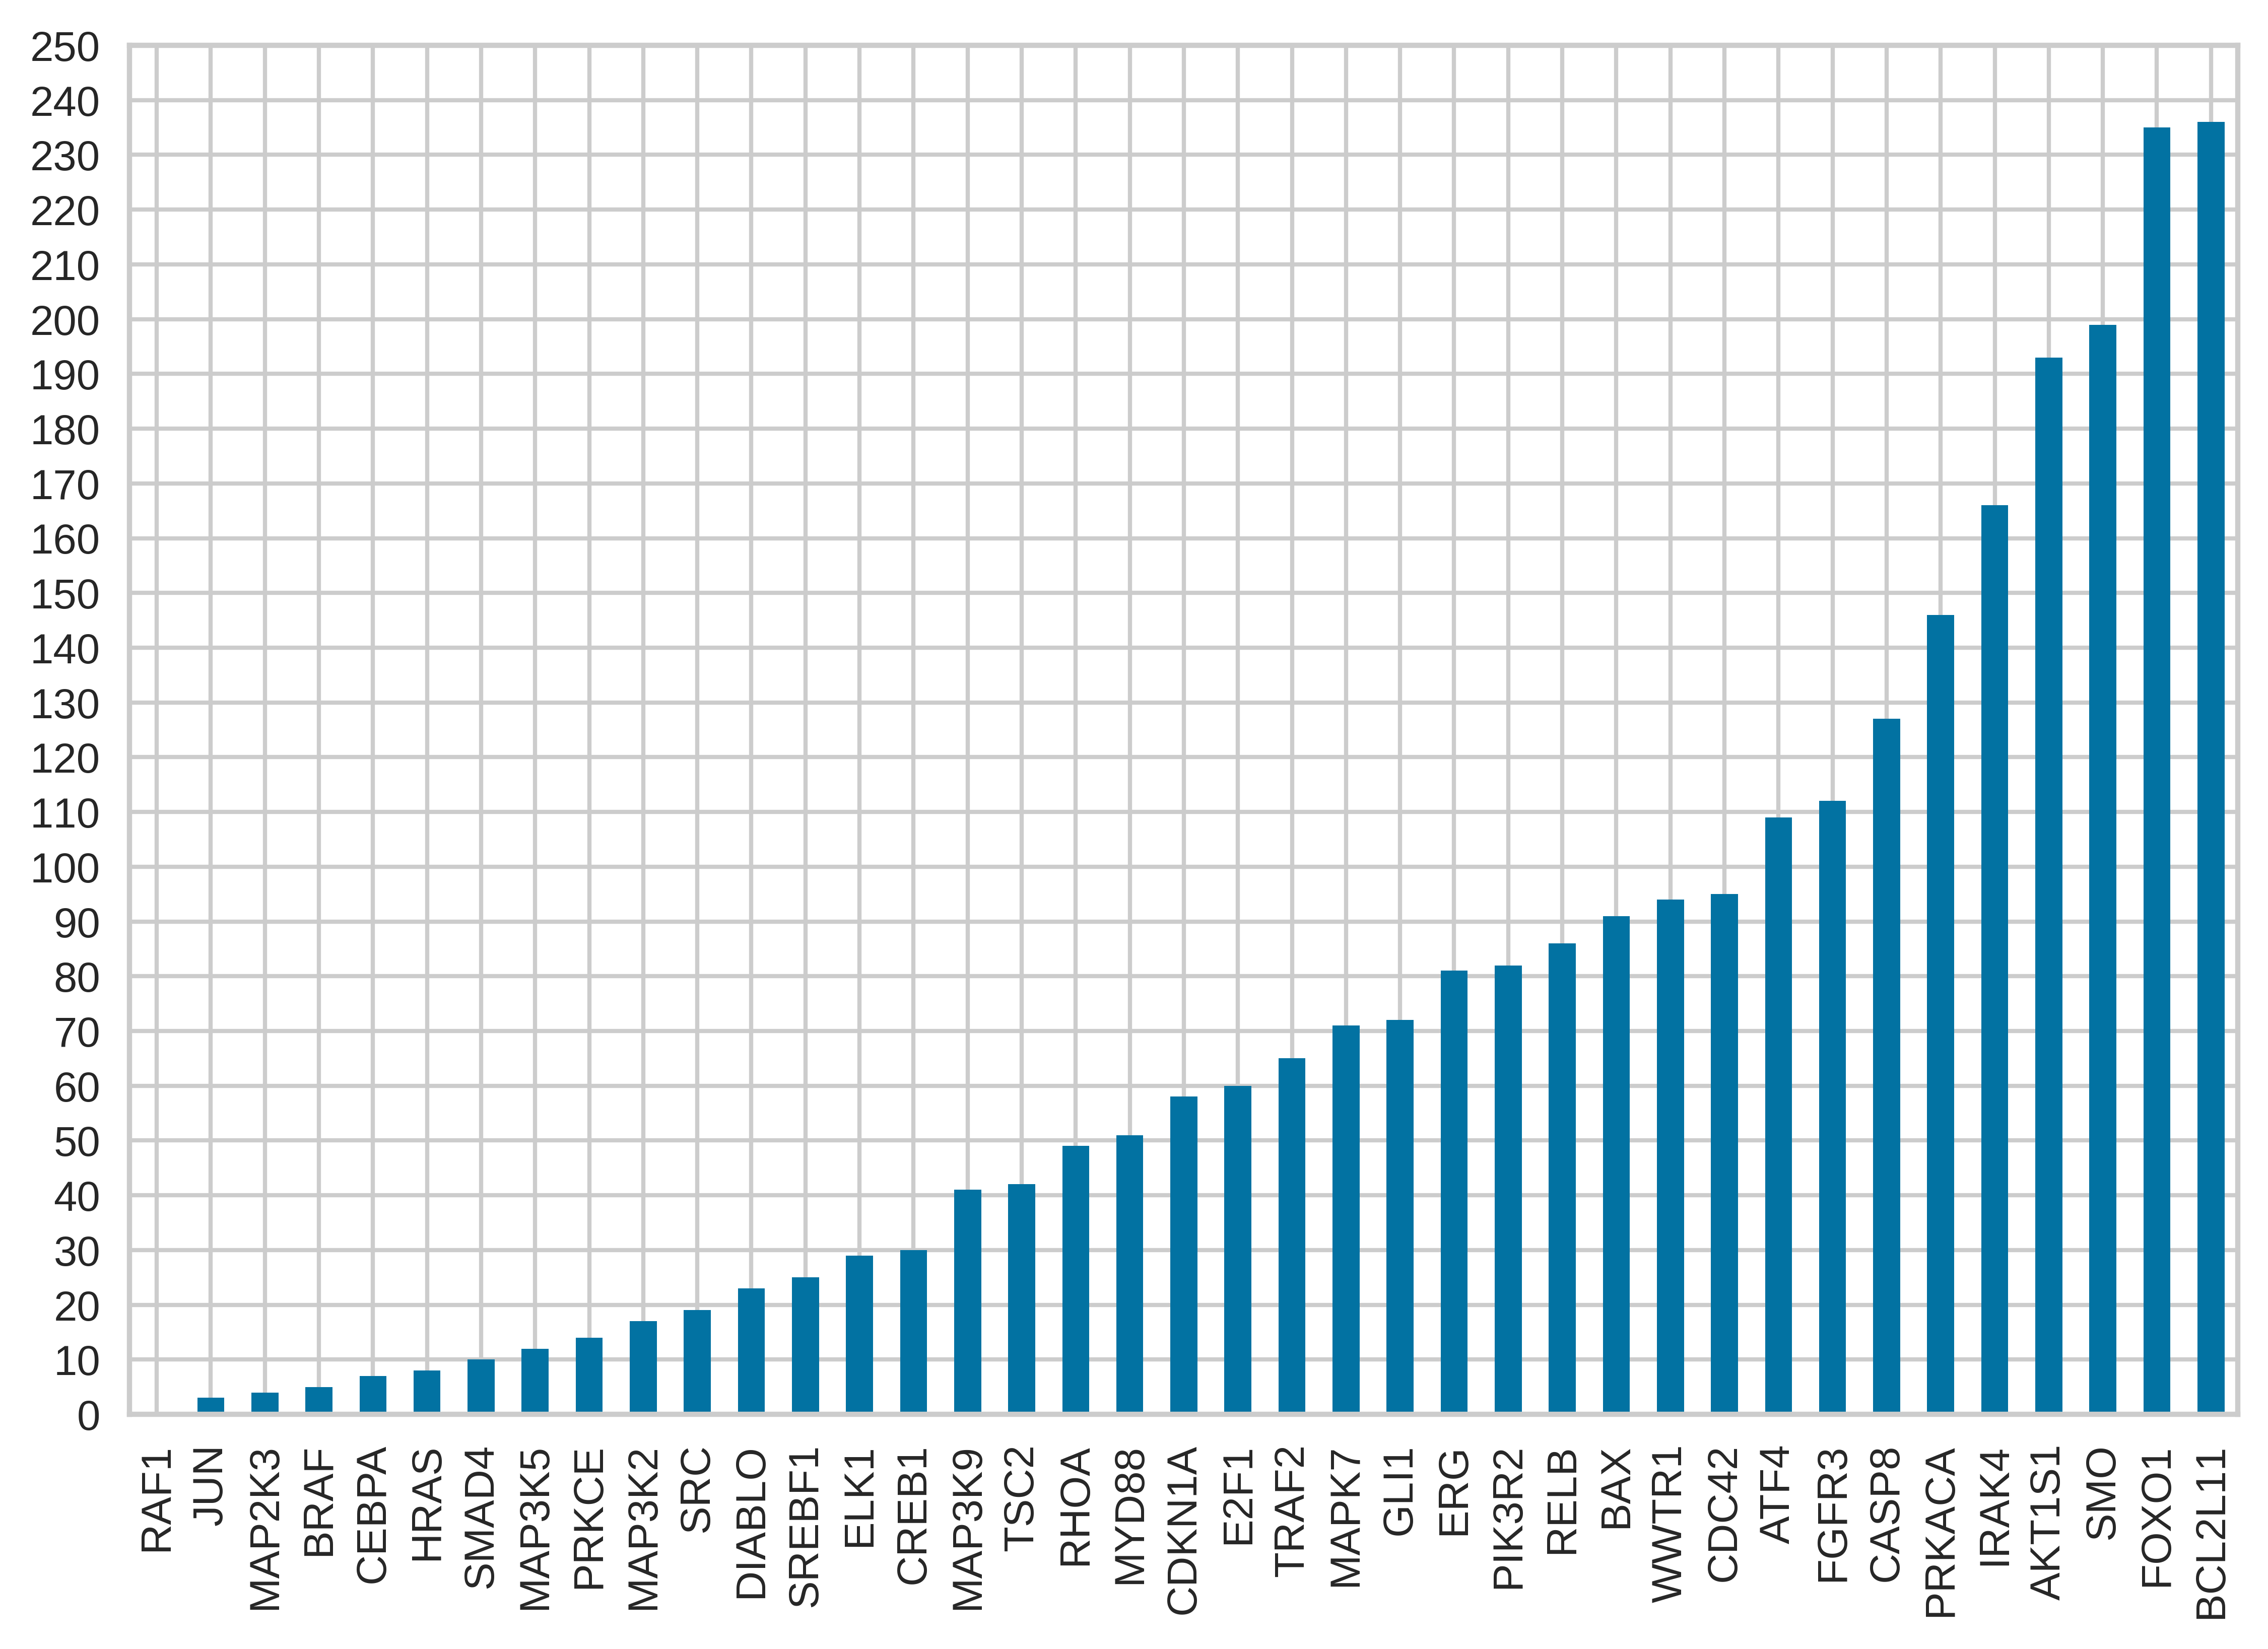

<IPython.core.display.Javascript object>

In [120]:
nn_38_hit_dict = get_knn_hit_data(nn38_pred_dict_101_s_phy)
ax = nn_38_hit_dict.knn_hit.sort_values().plot(kind="bar", figsize=[9, 6])
# ax.set_ylabel("k-neighbors")
# ax.set_title("Number of neighbors until target")
ax.set_yticks(range(0, 260, 10))
plt.show()

---

### Prediction with no cluster supervision

In [14]:
nn38_pred_dict_100_s_phy = get_linear_comb_translation_dict(
    reg_embs_dict=reg_embs_dict_100_s_phy,
    phy_embs_dict=phy_embs_dict_100_s_phy,
    n_neighbors=38,
    permute=False,
)

<IPython.core.display.Javascript object>

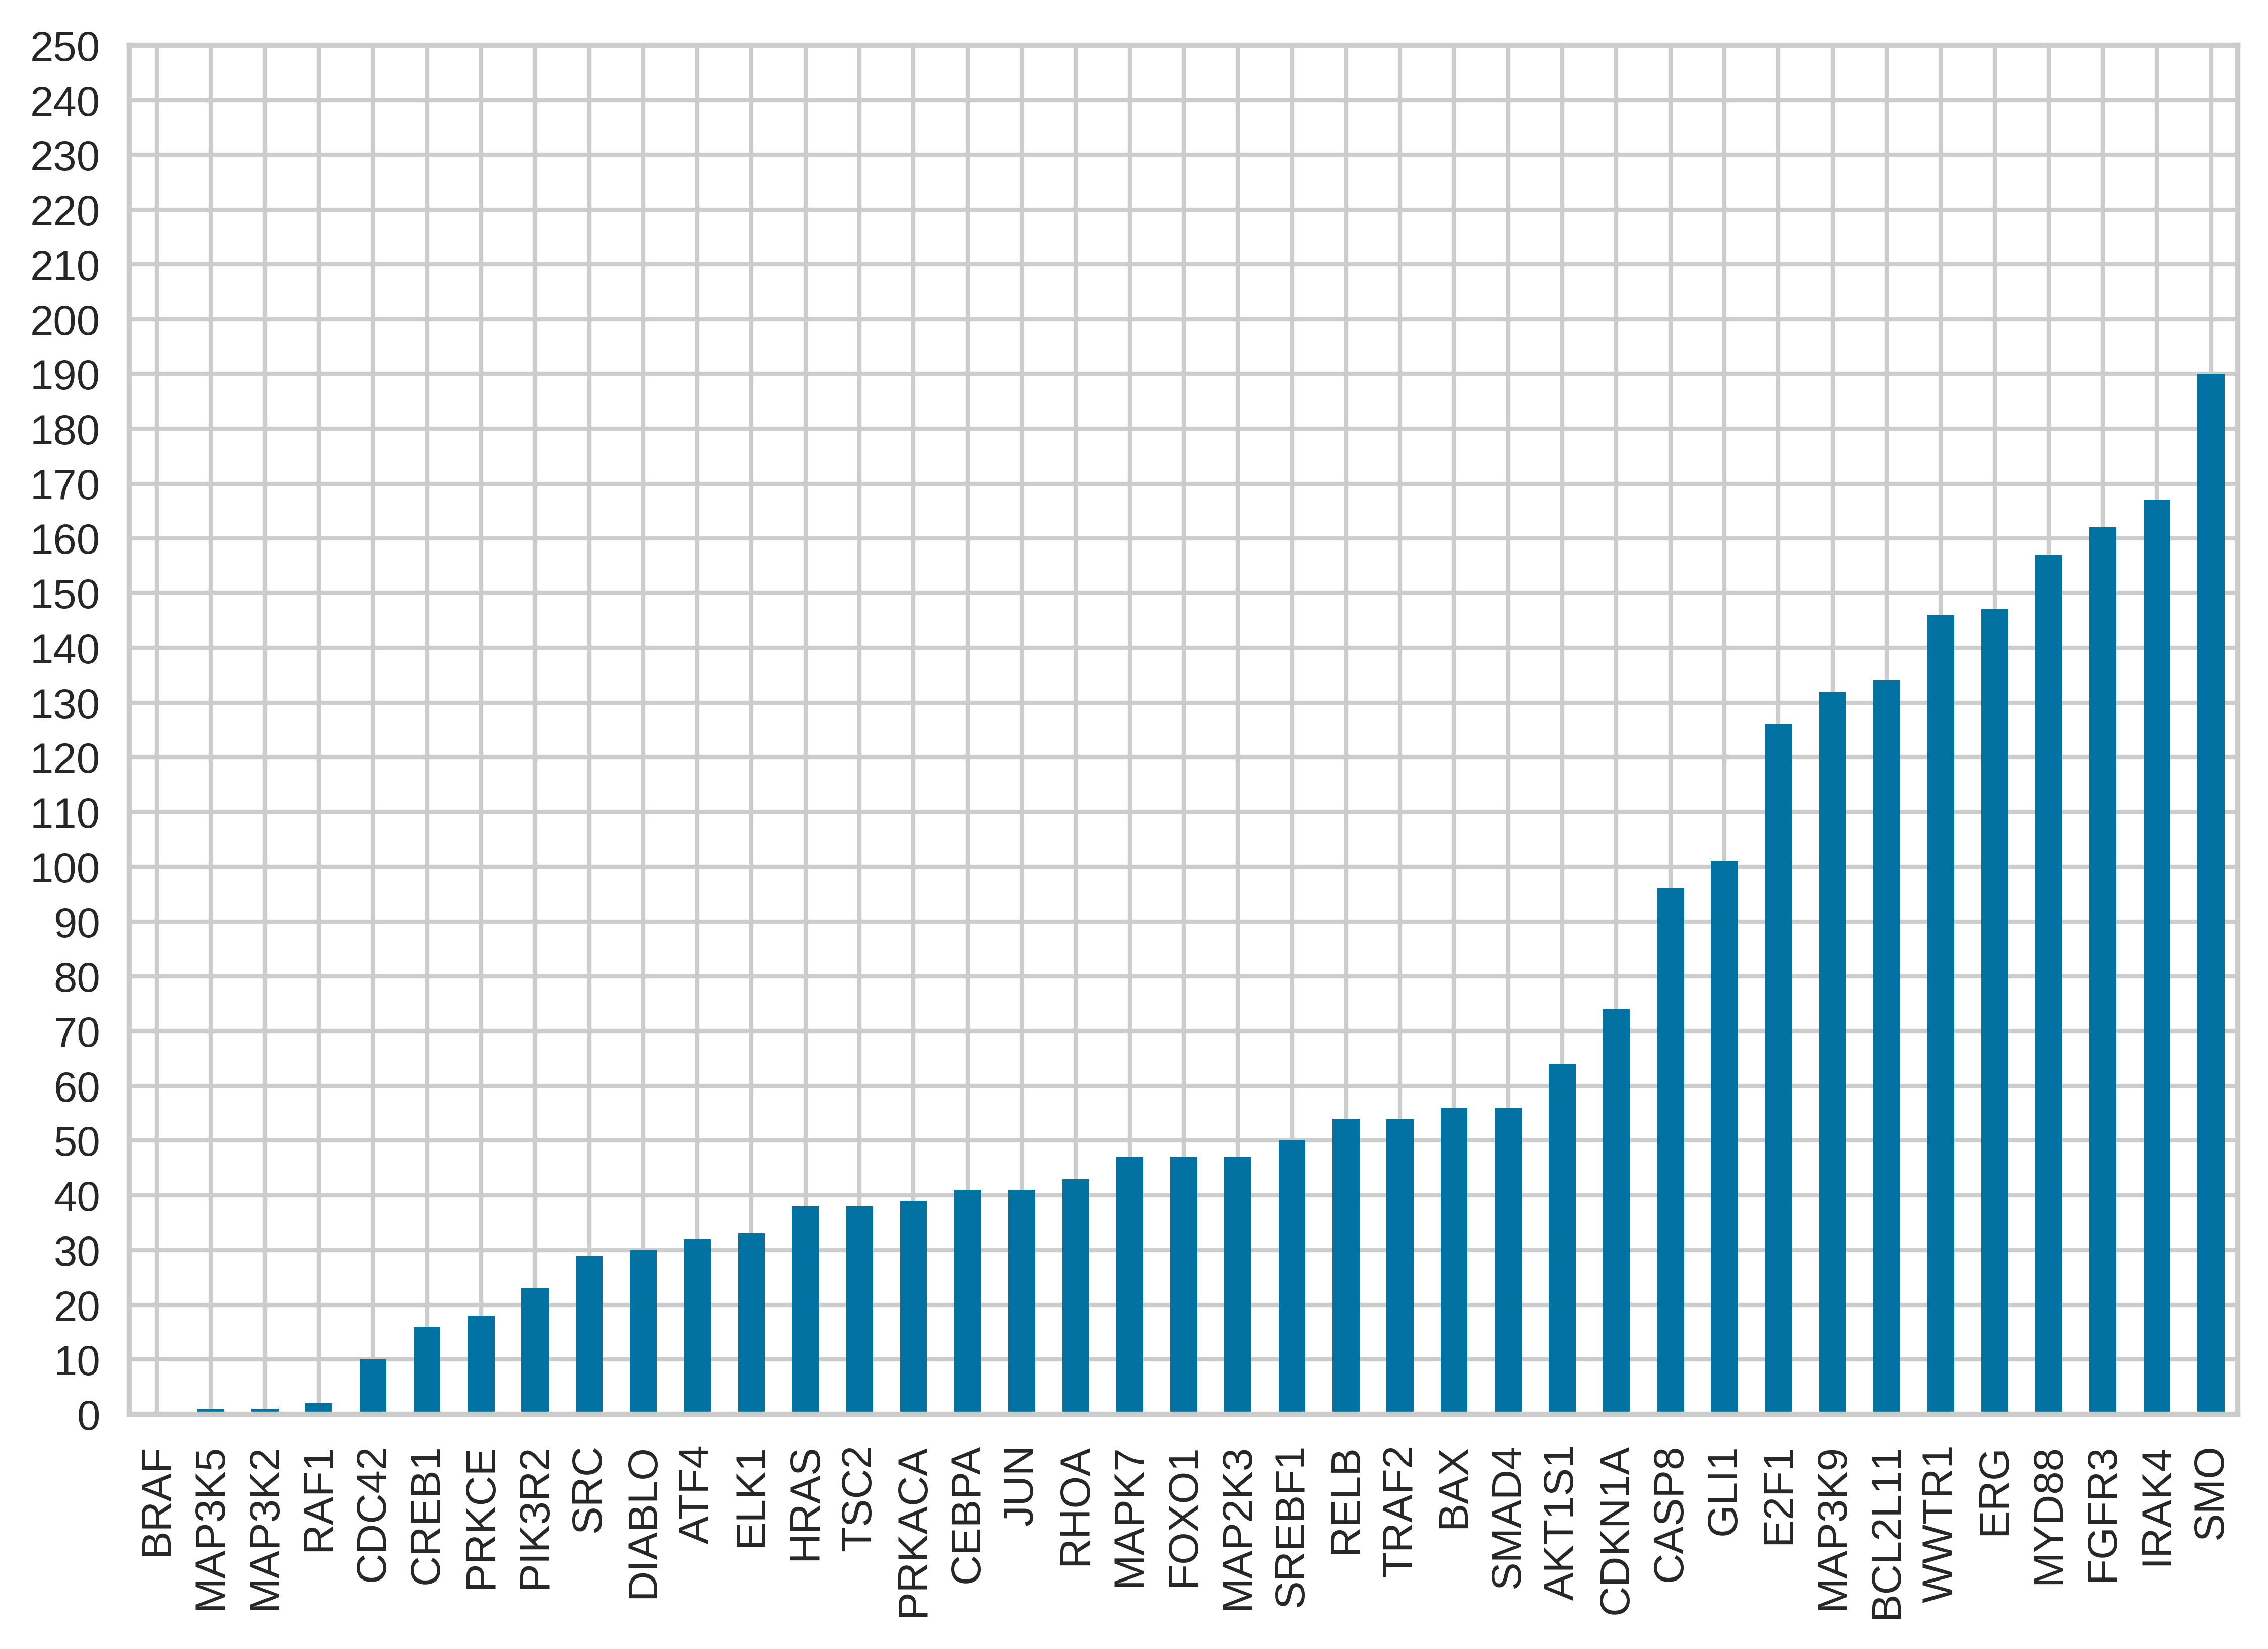

<IPython.core.display.Javascript object>

In [15]:
nn_38_hit_na_dict = get_knn_hit_data(nn38_pred_dict_100_s_phy)
ax = nn_38_hit_na_dict.knn_hit.sort_values().plot(kind="bar", figsize=[9, 6])
# ax.set_ylabel("k-neighbors")
# ax.set_title("Number of neighbors until target")
ax.set_yticks(range(0, 260, 10))
plt.show()